In [9]:
import joblib
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFE
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


from xgboost import XGBRegressor


In [10]:
# Load the dataset
df = pd.read_csv("../data/data.csv")

In [11]:

# Basic info
print(df["Workout_Frequency (days/week)"].value_counts())
print(df["Workout_Frequency (days/week)"].describe())

Workout_Frequency (days/week)
3    368
4    306
2    197
5    102
Name: count, dtype: int64
count    973.000000
mean       3.321686
std        0.913047
min        2.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: Workout_Frequency (days/week), dtype: float64


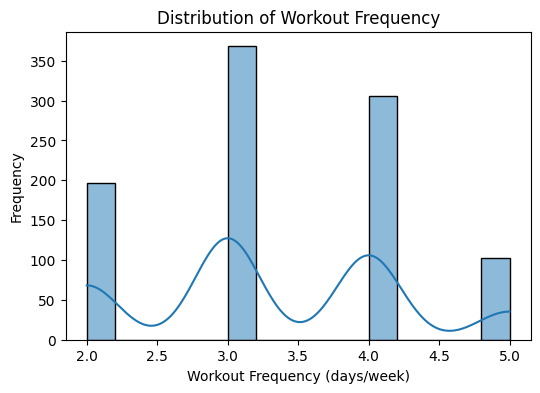

In [12]:
# Distribution plot
plt.figure(figsize=(6, 4))
sns.histplot(df["Workout_Frequency (days/week)"], kde=True)
plt.title("Distribution of Workout Frequency")
plt.xlabel("Workout Frequency (days/week)")
plt.ylabel("Frequency")
plt.show()

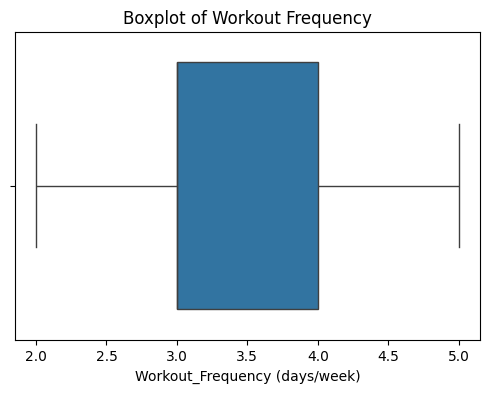

In [13]:
# Boxplot for outlier detection
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["Workout_Frequency (days/week)"])
plt.title("Boxplot of Workout Frequency")
plt.show()

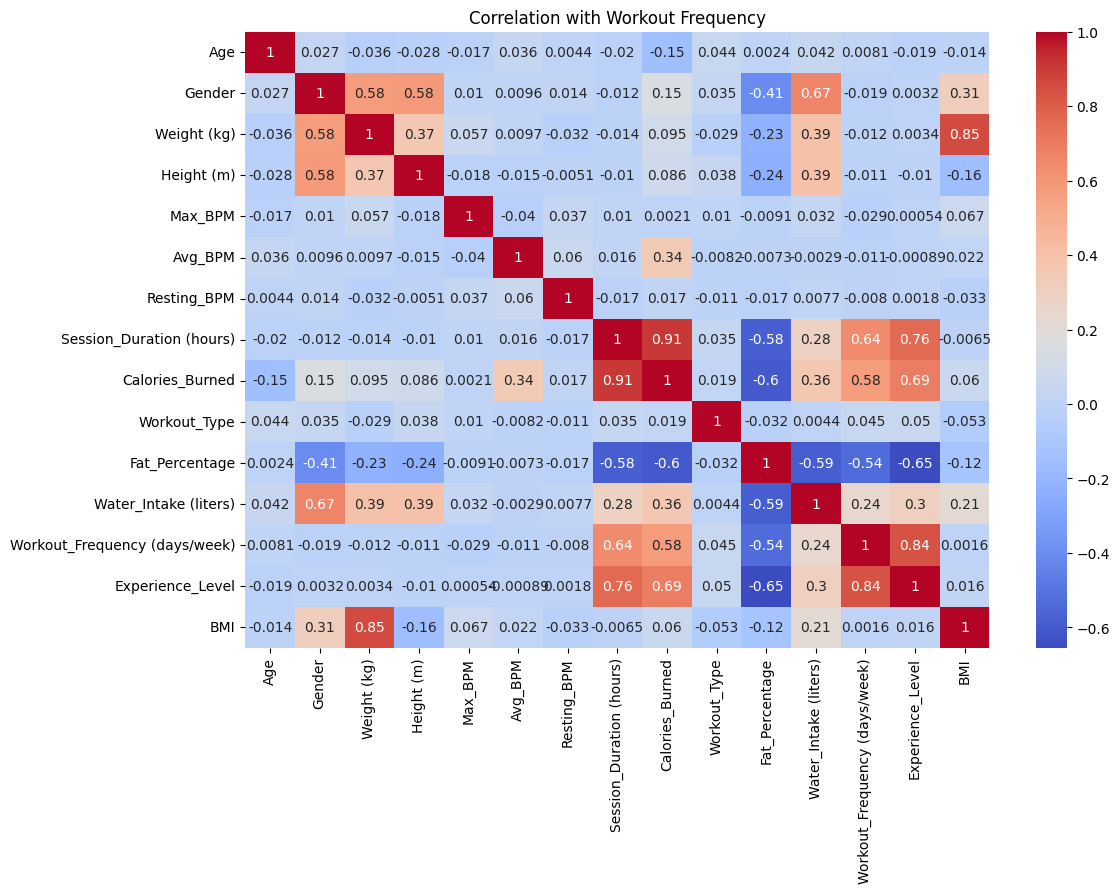

In [21]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation with Workout Frequency")
plt.show()

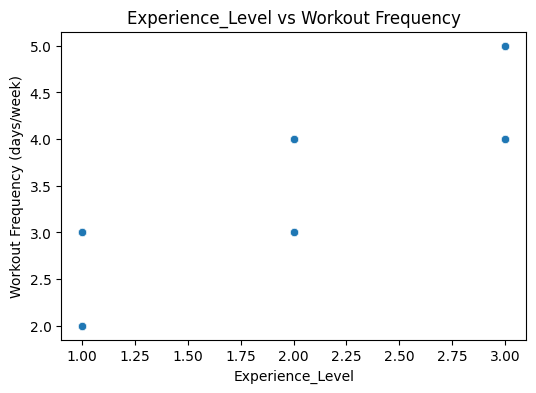

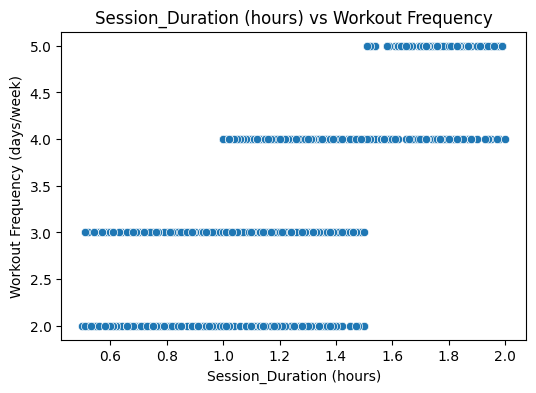

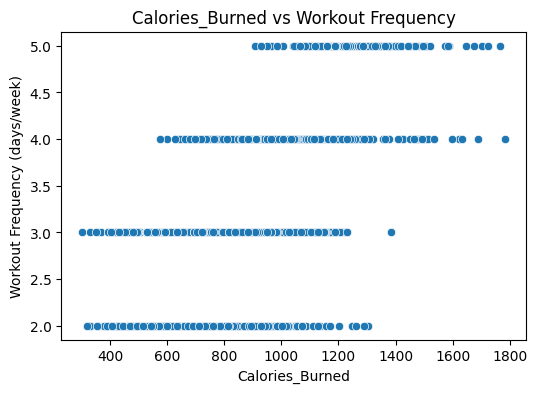

In [22]:
# Scatter plots with top correlated features
top_corr = df.corr(numeric_only=True)["Workout_Frequency (days/week)"].abs().sort_values(ascending=False)[1:4]
for feature in top_corr.index:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[feature], y=df["Workout_Frequency (days/week)"])
    plt.title(f"{feature} vs Workout Frequency")
    plt.xlabel(feature)
    plt.ylabel("Workout Frequency (days/week)")
    plt.show()

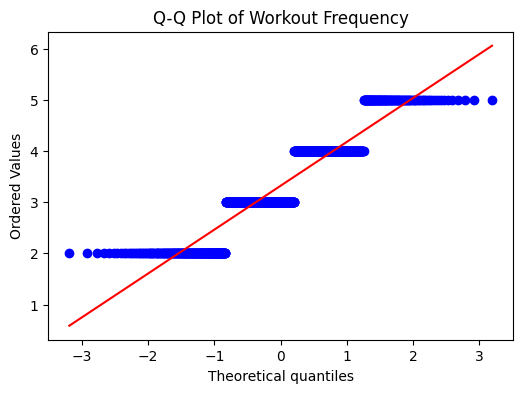

In [24]:
# Q-Q plot for normality
from scipy import stats


plt.figure(figsize=(6, 4))
stats.probplot(df["Workout_Frequency (days/week)"], dist="norm", plot=plt)
plt.title("Q-Q Plot of Workout Frequency")
plt.show()

In [14]:



# Encode categorical features
df_encoded = df.copy()
label_encoders = {}

for col in ['Gender', 'Workout_Type']:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

df = df_encoded.copy()    

# Separate features and target
X = df_encoded.drop(columns=['Workout_Frequency (days/week)'])
y = df_encoded['Workout_Frequency (days/week)']

# Feature selection using RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
rf_importances = pd.Series(rf.feature_importances_, index=X.columns)

# Feature selection using SelectKBest (mutual information)
selector = SelectKBest(score_func=mutual_info_regression, k='all')
selector.fit(X, y)
mi_scores = pd.Series(selector.scores_, index=X.columns)

# Combine both results
feature_scores = pd.DataFrame({
    'RandomForest_Importance': rf_importances,
    'Mutual_Info_Score': mi_scores
}).sort_values(by='RandomForest_Importance', ascending=False)

# Display sorted feature scores
print(feature_scores)



                          RandomForest_Importance  Mutual_Info_Score
Experience_Level                         0.544596           0.574503
Fat_Percentage                           0.166884           0.290879
Session_Duration (hours)                 0.037895           0.359448
Max_BPM                                  0.032468           0.000000
BMI                                      0.030792           0.018542
Age                                      0.029962           0.000000
Weight (kg)                              0.028942           0.144154
Calories_Burned                          0.027201           0.220596
Avg_BPM                                  0.025889           0.019163
Resting_BPM                              0.025689           0.000000
Height (m)                               0.022869           0.000000
Water_Intake (liters)                    0.017236           0.223205
Workout_Type                             0.008408           0.000000
Gender                            

In [15]:
df

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,1,88.3,1.71,180,157,60,1.69,1313.0,3,12.6,3.5,4,3,30.20
1,46,0,74.9,1.53,179,151,66,1.30,883.0,1,33.9,2.1,4,2,32.00
2,32,0,68.1,1.66,167,122,54,1.11,677.0,0,33.4,2.3,4,2,24.71
3,25,1,53.2,1.70,190,164,56,0.59,532.0,2,28.8,2.1,3,1,18.41
4,38,1,46.1,1.79,188,158,68,0.64,556.0,2,29.2,2.8,3,1,14.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,24,1,87.1,1.74,187,158,67,1.57,1364.0,2,10.0,3.5,4,3,28.77
969,25,1,66.6,1.61,184,166,56,1.38,1260.0,2,25.0,3.0,2,1,25.69
970,59,0,60.4,1.76,194,120,53,1.72,929.0,0,18.8,2.7,5,3,19.50
971,32,1,126.4,1.83,198,146,62,1.10,883.0,1,28.2,2.1,3,2,37.74


In [16]:


# Use the previously engineered features as input
X = df.drop(columns=['Workout_Frequency (days/week)'])
y = df['Workout_Frequency (days/week)']

# Initialize Random Forest model
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)

# Recursive Feature Elimination to select top 5 features (you can adjust n_features_to_select)
rfe = RFE(estimator=rf, n_features_to_select=5)
rfe.fit(X, y)

# Selected features mask
selected_mask = rfe.support_

# List selected feature names
best_features = X.columns[selected_mask].tolist()

print("Best features selected by RFE:")
print(best_features)


Best features selected by RFE:
['Weight (kg)', 'Session_Duration (hours)', 'Fat_Percentage', 'Experience_Level', 'BMI']


In [17]:


selected_features = ['Weight (kg)', 'Session_Duration (hours)', 'Fat_Percentage', 'Experience_Level', 'BMI']
X = df[selected_features]
y = df['Workout_Frequency (days/week)']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=30, cv=5, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

cv_scores = cross_val_score(best_model, X_scaled, y, cv=5, scoring='r2')

print(f"Best Params: {random_search.best_params_}")
print(f"Training R²: {train_r2:.4f}")
print(f"Testing R²: {test_r2:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Testing MAE: {test_mae:.4f}")
print(f"CV R² Scores: {cv_scores}")
print(f"Mean CV R² Score: {np.mean(cv_scores):.4f}")



Best Params: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Training R²: 0.7441
Testing R²: 0.7141
Training MAE: 0.4457
Testing MAE: 0.5063
CV R² Scores: [0.65826249 0.64657331 0.72145075 0.65140843 0.69151831]
Mean CV R² Score: 0.6738


In [18]:


# Save the best model to a file
joblib.dump(best_model, '../models/workout-frequency/workout_frequency_model.pkl')

# Save the scaler too
joblib.dump(scaler, '../models/workout-frequency/workout_frequency_scaler.pkl')


['../models/workout-frequency/workout_frequency_scaler.pkl']

In [19]:
# To load the model and scaler again
best_model = joblib.load('../models/workout-frequency/workout_frequency_model.pkl')
scaler = joblib.load('../models/workout-frequency/workout_frequency_scaler.pkl')


In [20]:
# 5 custom test inputs: [Weight, Session_Duration, Fat_Percentage, Experience_Level, BMI]
custom_data = pd.DataFrame([
    [70, 1.5, 18, 2, 22.5],
    [85, 2.0, 25, 3, 27.8],
    [60, 1.0, 15, 1, 20.1],
    [95, 2.5, 30, 3, 31.4],
    [78, 1.8, 22, 3, 25.0]
], columns=['Weight (kg)', 'Session_Duration (hours)', 'Fat_Percentage', 'Experience_Level', 'BMI'])

# Scale the data using the saved scaler
custom_scaled = scaler.transform(custom_data)

# Predict using the trained model
custom_predictions = best_model.predict(custom_scaled)

# Display predictions
for i, pred in enumerate(custom_predictions, 1):
    print(f"Sample {i} - Predicted Workout Frequency (days/week): {pred:.2f}")


Sample 1 - Predicted Workout Frequency (days/week): 4.45
Sample 2 - Predicted Workout Frequency (days/week): 3.68
Sample 3 - Predicted Workout Frequency (days/week): 2.83
Sample 4 - Predicted Workout Frequency (days/week): 3.64
Sample 5 - Predicted Workout Frequency (days/week): 3.63
